In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import gpytorch
import tqdm

base_dir = os.path.join(os.getcwd(), '../../')
sys.path.append(base_dir)

from src.kernels import CMEAggregateKernel
from src.means import CMEAggregateMean
from src.models import ExactCMEProcess

## Simulation Data

For this 2D simulation data, we work with a bidimensional field $f(x_1, x_2)$ and use an uniform aggregation process over disk of radius $r$ centered in $y = (y_1, y_2)$ as

$$
g(y) = \int\int f(x_1, x_2)d\mathcal{U}_{D(y, r)}(x_1, x_2)
$$

We choose $f$ in order to obtain a closed form expression for $g$.

For simplicity, we choose $f(x_1, x_2) = x_1^2 + x_2^2$ which happens to yield $g(y) = r\|y\|_2^2 + \frac{r^3}{3}$

In [2]:
def generate_toy_2d_dataset(n_bags, radius, img_range, img_size, noise_std, seed):
    torch.random.manual_seed(seed)
    
    # Create 2D grid corresponding to specified dimensions
    x1 = torch.linspace(0, img_range, img_size)
    x2 = torch.linspace(0, img_range, img_size)
    x = torch.stack(torch.meshgrid(x1, x2), dim=-1)
    
    # Compute individuals groundtruth grid
    x_square_norm = x.pow(2).sum(dim=-1)

    # Draw random positions corresponding to bags
    y = img_range * torch.rand(n_bags, 2)
    y_square_norm = y.pow(2).sum(dim=-1)

    # Compute appropriate circular masks around drawn locations
    bags_masks = [torch.pow(x - a, 2).sum(dim=-1) <= radius**2 for a in y]
    individuals = torch.cat([x[mask] for mask in bags_masks])
    bags_sizes = [torch.sum(mask).item() for mask in bags_masks]

    # Compute aggregate bag values and add observation noise
    primitive = lambda r, y_square_norm: r * y_square_norm + r**3 / 3
    latent_aggregate_targets = primitive(radius, y_square_norm)
    aggregate_targets = latent_aggregate_targets + noise_std * torch.randn_like(latent_aggregate_targets)

    return x, x_square_norm, y, individuals, aggregate_targets, bags_sizes, bags_masks

seed = 5
n_bags = 40
radius = 1
img_range = 10
img_size = 60
noise_std = 0.025

buffer = generate_toy_2d_dataset(seed=seed,
                                 n_bags=n_bags,
                                 radius=radius,
                                 img_range=img_range,
                                 img_size=img_size,
                                 noise_std=noise_std)

x, x_square_norm, y, individuals, aggregate_targets, bags_sizes, bags_masks = buffer

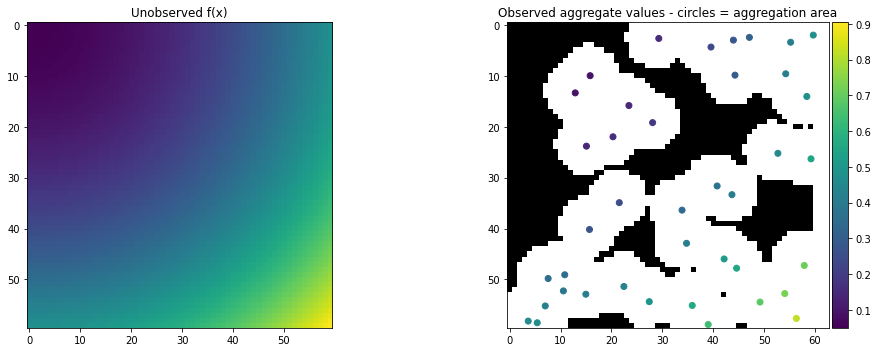

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)

scaled_y = img_size / img_range * y
foo = aggregate_targets.numpy()
normalized_bags_targets = (foo - x_square_norm.min().item()) / (x_square_norm.max().item() - x_square_norm.min().item())
centroids_colors = [plt.cm.viridis(x) for x in normalized_bags_targets]

ax[0].imshow(x_square_norm)
ax[0].set_title('Unobserved f(x)')
ax[1].imshow(torch.stack(bags_masks).any(dim=0), cmap='gray')
ax[1].scatter(scaled_y[:, 1], scaled_y[:, 0], c=centroids_colors)
ax[1].set_title('Observed aggregate values - circles = aggregation area')

mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array(normalized_bags_targets)
cbar = fig.colorbar(mappable, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

## Define CME Process Model

In [4]:
individuals_mean = gpytorch.means.ZeroMean()
individuals_kernel = gpytorch.kernels.LinearKernel(active_dims=torch.tensor([0, 1]), ard_num_dims=2)
bag_kernel = gpytorch.kernels.LinearKernel(active_dims=torch.tensor([0, 1]), ard_num_dims=2)

model = ExactCMEProcess(individuals_mean=individuals_mean, 
                        individuals_kernel=individuals_kernel,
                        bag_kernel=bag_kernel,
                        train_individuals=individuals,
                        train_bags=y,
                        train_aggregate_targets=aggregate_targets,
                        bags_sizes=bags_sizes,
                        lbda=1e-3,
                        likelihood=gpytorch.likelihoods.GaussianLikelihood())

## MLE estimate of hyperparameters

In [21]:
model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(params=model.parameters(), lr=.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

epochs = 40

epoch_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
for i in epoch_iter:
    optimizer.zero_grad()
    output = model(y)
    loss = -mll(output, aggregate_targets)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.update_cme_estimate_parameters()
    epoch_iter.set_postfix(loss=loss.item())

print("Final Marginal Likelihood : ", torch.exp(-loss).item())


Final Marginal Likelihood :  1.2756576297197804e-22


## Predict

In [22]:
model.eval()
model.likelihood.eval()

with torch.no_grad():
    individuals_posterior = model.predict(x.reshape(-1, 2))

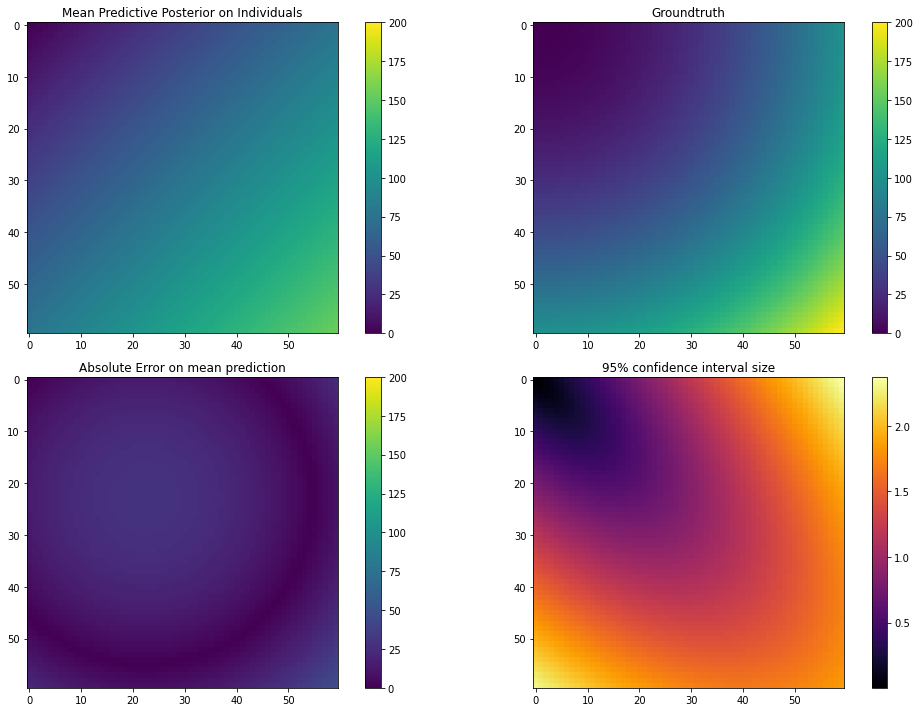

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Normalize ranges of groundtruth and mean predictions for visual comparison
mean_prediction = individuals_posterior.mean.reshape(img_size, img_size)
full_tensor = torch.stack([mean_prediction, x_square_norm]).numpy()
norm = matplotlib.colors.Normalize(vmin=full_tensor.min(),
                                   vmax=full_tensor.max())


lower, upper = individuals_posterior.confidence_region()
lower, upper = lower.detach(), upper.detach()
confidence = upper.sub(lower).view(img_size, img_size)

im1 = ax[0, 0].imshow(mean_prediction, norm=norm)
fig.colorbar(im1, ax=ax[0, 0])
ax[0, 0].set_title("Mean Predictive Posterior on Individuals")

im2 = ax[0, 1].imshow(x_square_norm, norm=norm)
fig.colorbar(im2, ax=ax[0, 1])
ax[0, 1].set_title("Groundtruth")


im3 = ax[1, 0].imshow(torch.abs(mean_prediction - x_square_norm), cmap='viridis', norm=norm)
fig.colorbar(im3, ax=ax[1, 0])
ax[1, 0].set_title("Absolute Error on mean prediction")


im4 = ax[1, 1].imshow(confidence, cmap='inferno')
fig.colorbar(im4, ax=ax[1, 1])
ax[1, 1].set_title("95% confidence interval size")


plt.tight_layout()
plt.show()